# Traveling Salesman Problem by Simulated Annealing

## I. Introduction

Simulated annealing is a probablistic technique used for finding an approximate solution to an optimization problem. In this project, a [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) algorithm is implemented to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals. The TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once. The TSP path is defined to start and end in the same city, i.e., a closed loop. 

In [40]:
import json
import copy

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
import sys
import math
from time import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

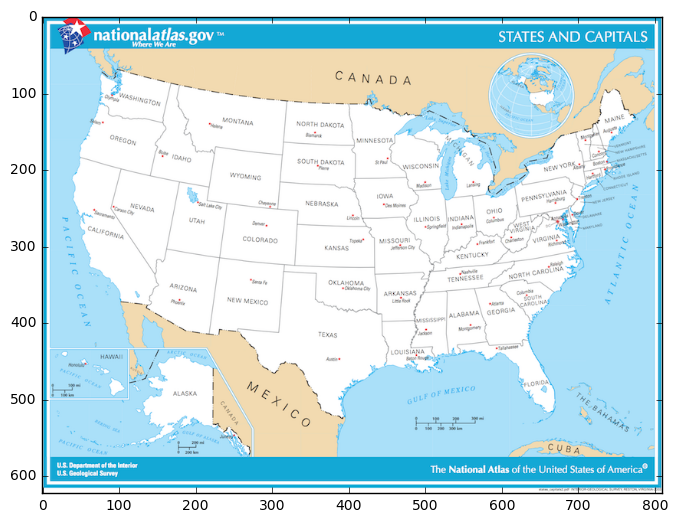

In [2]:
"""Read map data"""
# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# More information in http://www.usgs.gov/visual-id/credit_usgs.html
map = mpimg.imread("map.png")  # US States & Capitals map

# show map
plt.figure(figsize=(8, 8))
plt.imshow(map);

In [3]:
"""Read json input data"""

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())
capitals_list

[('Harrisburg', [670.8, 244.0]),
 ('Oklahoma City', [392.8, 356.4]),
 ('Columbus', [590.8, 263.2]),
 ('Providence', [735.2, 201.2]),
 ('Montgomery', [559.6, 404.8]),
 ('Austin', [389.2, 448.4]),
 ('Richmond', [673.2, 293.6]),
 ('Boston', [738.4, 190.8]),
 ('Raleigh', [662.0, 328.8]),
 ('Salt Lake City', [204.0, 243.2]),
 ('Salem', [80.0, 139.2]),
 ('Jackson', [501.6, 409.6]),
 ('Phoenix', [179.6, 371.2]),
 ('Atlanta', [585.6, 376.8]),
 ('Lansing', [563.6, 216.4]),
 ('Hartford', [719.6, 205.2]),
 ('Columbia', [632.4, 364.8]),
 ('Denver', [293.6, 274.0]),
 ('Saint Paul', [451.6, 186.0]),
 ('Tallahassee', [594.8, 434.8]),
 ('Trenton', [698.8, 239.6]),
 ('Sacramento', [68.4, 254.0]),
 ('Baton Rouge', [489.6, 442.0]),
 ('Little Rock', [469.2, 367.2]),
 ('Albany', [702.0, 193.6]),
 ('Des Moines', [447.6, 246.0]),
 ('Nashville', [546.4, 336.8]),
 ('Boise', [159.6, 182.8]),
 ('Madison', [500.8, 217.6]),
 ('Indianapolis', [548.0, 272.8])]

In [4]:
"""Define visualization helper functions"""

def show_path(path, starting_city, w=12, h=8):
    """Plot path overlaid on the given map."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y*: yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

## II. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.

In [13]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time.
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
    """ 
    current_state = problem
    t_min = 1e-10
    for t in range(sys.maxsize):
        T = schedule(t)
        
        # termination condition
        if T <= t_min:
            return current_state
        
        # randomly pick a successor of the current state as the next state
        next_state = random.choice(current_state.successors())
        # next_state is none
        if not next_state:
            return current_state
        # next_state is not none
        delta_E = next_state.get_value() - current_state.get_value()
        if delta_E > 0 or random.random() < math.exp(delta_E/T):
            current_state = next_state

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques. Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid. The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [6]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem. The goal
    is to find the shortest path that visits every city only once in a closed loop path.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. 
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. 
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited. 
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        
        neighbors = []
        # loop over all cities in the path
        for i in range(0, len(self.path)):
            copy = self.path[:]
            tmp = copy[i]
            
            if i != (len(self.path) - 1):
                # not the end of list
                # switch the i'th and (i+1)th elements
                copy[i] = copy[i+1]
                copy[i+1] = tmp
            else:
                # if to the last element in list, wrap it with the first element
                copy[i] = copy[0]
                copy[0] = tmp
            
            neighbors.append(TravelingSalesmanProblem(copy))
        
        return neighbors

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities. Note: 
        the path length is multiplied by -1 because the default simulated annealing 
        algorithm seeks to maximize the objective function, i.e., minimize path length
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        """
        total_length = 0
        
        # loop over all cities in the path
        for i in range(0, len(self.path)):
            copy = self.path[:]
            x1, y1 = copy[i][1]
            
            if i != (len(self.path) - 1):
                # not the end of list, get coords of next city in list
                x2, y2 = copy[i+1][1]
            else:
                # if the end of list, get the coords of the first city in list
                x2, y2 = copy[0][1]
                
            total_length += (-1) * math.sqrt((x2-x1)**2 + (y2-y1)**2)
        
        return total_length

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [7]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [8]:
# Test the successors() method 
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [9]:
# Test the get_value() method 
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## IV. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  

In [10]:
# define exponential temperature schedule
alpha = 0.95
temperature=1e4

def schedule(time):
    return temperature * (alpha**time)

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [11]:
# test the schedule() function 
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [14]:
# test if simulated_annealing() with the exponential decay schedule() optimizes the path
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3)), ('DC', (11, 1))]


### Experiment with Other Schedule Functions

Other cooling schedule functions we can use, including:

- linear schedule: the temperature decrease is made multiplying $T_0$ by a factor that decreases in inverse proportion to the time, i.e., $T(t) = T_0 / (1 + \alpha t)$ with $\alpha > 0$    
- quadratic schedule: the temperature decrease is made multiplying $T_0$ by a factor that decreases in inverse proportion to the square of time, i.e., $T(t) = T_0 / (1 + \alpha t^2)$ with $\alpha > 0$  
- logarithmical schedule: the temperature decrease is made multiplying $T_0$ by a factor that decreases in inverse proportion to the natural logarithm of time, i.e., $T(t) = T_0 / (1 + \alpha log(t + 1))$ with $\alpha > 1$  

In [32]:
# linear temperature schedule 
def schedule_linear(time):
    return temperature/(1 + alpha*time)

In [33]:
# quardratic temperature schedule 
def schedule_quad(time):
    return temperature/(1 + alpha*(time**2))

In [38]:
# logarithmical temperature schedule 
alpha_log = 2
def schedule_log(time):
    return temperature/(1 + alpha_log*log(time+1))

## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

Start with `num_cities` equal to 10 and then increase it to 30.

### Without Simulated Annealing

Initial path value: 2656.25
[('Harrisburg', [670.8, 244.0]), ('Oklahoma City', [392.8, 356.4]), ('Columbus', [590.8, 263.2]), ('Providence', [735.2, 201.2]), ('Montgomery', [559.6, 404.8]), ('Austin', [389.2, 448.4]), ('Richmond', [673.2, 293.6]), ('Boston', [738.4, 190.8]), ('Raleigh', [662.0, 328.8]), ('Salt Lake City', [204.0, 243.2])]


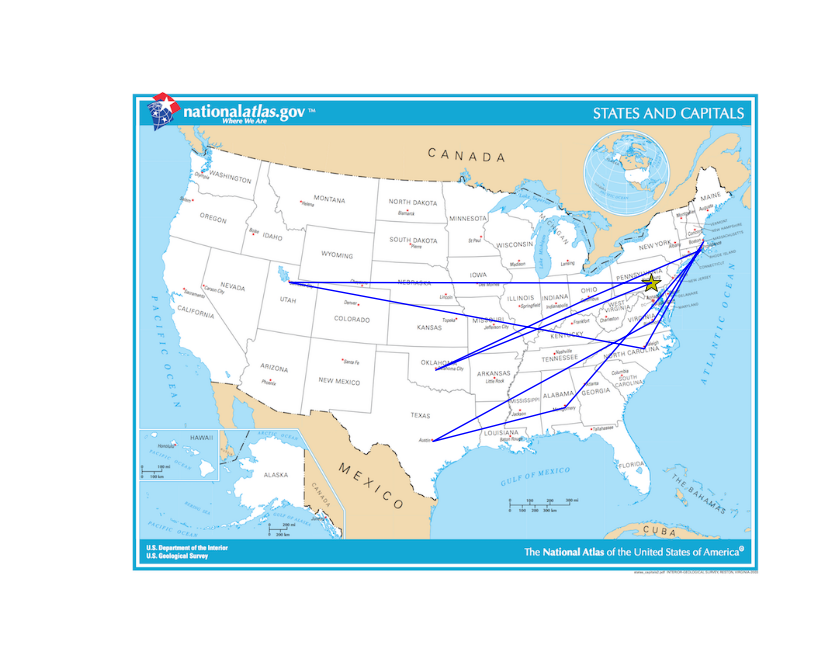

In [18]:
"""Simulation with num_cities = 10 -- without simulated annealing"""
# Create the problem instance and plot the initial state
num_cities = 10
capitals_tsp_10 = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp_10.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp_10.coords, starting_city)

Initial path value: 7934.24
[('Harrisburg', [670.8, 244.0]), ('Oklahoma City', [392.8, 356.4]), ('Columbus', [590.8, 263.2]), ('Providence', [735.2, 201.2]), ('Montgomery', [559.6, 404.8]), ('Austin', [389.2, 448.4]), ('Richmond', [673.2, 293.6]), ('Boston', [738.4, 190.8]), ('Raleigh', [662.0, 328.8]), ('Salt Lake City', [204.0, 243.2]), ('Salem', [80.0, 139.2]), ('Jackson', [501.6, 409.6]), ('Phoenix', [179.6, 371.2]), ('Atlanta', [585.6, 376.8]), ('Lansing', [563.6, 216.4]), ('Hartford', [719.6, 205.2]), ('Columbia', [632.4, 364.8]), ('Denver', [293.6, 274.0]), ('Saint Paul', [451.6, 186.0]), ('Tallahassee', [594.8, 434.8]), ('Trenton', [698.8, 239.6]), ('Sacramento', [68.4, 254.0]), ('Baton Rouge', [489.6, 442.0]), ('Little Rock', [469.2, 367.2]), ('Albany', [702.0, 193.6]), ('Des Moines', [447.6, 246.0]), ('Nashville', [546.4, 336.8]), ('Boise', [159.6, 182.8]), ('Madison', [500.8, 217.6]), ('Indianapolis', [548.0, 272.8])]


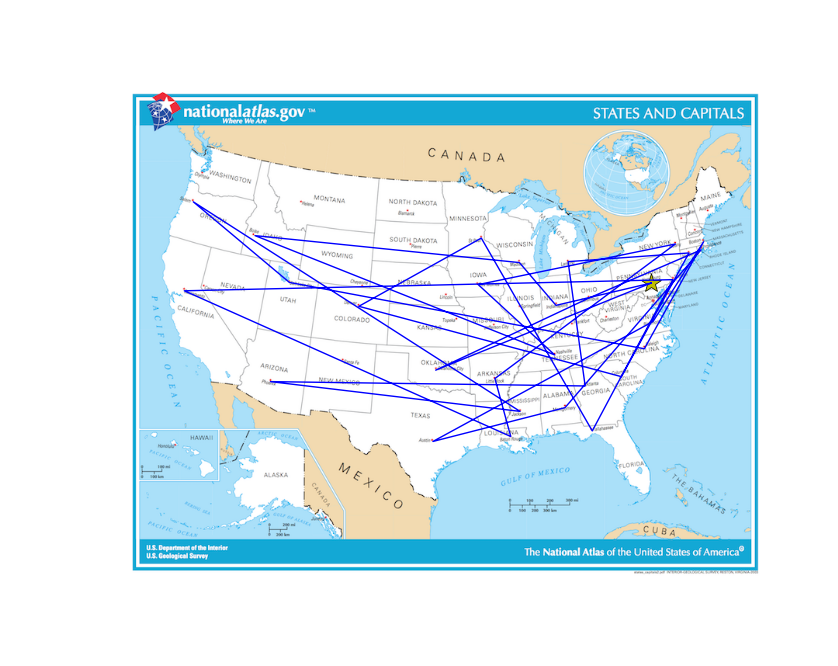

In [19]:
"""Simulation with num_cities = 10 -- without simulated annealing"""
# Create the problem instance and plot the initial state
num_cities = 30
capitals_tsp_30 = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp_30.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp_30.coords, starting_city)

### With Simulated Annealing - Exponential Schedule

Final path length: 2054.85
[('Salt Lake City', [204.0, 243.2]), ('Providence', [735.2, 201.2]), ('Raleigh', [662.0, 328.8]), ('Oklahoma City', [392.8, 356.4]), ('Austin', [389.2, 448.4]), ('Montgomery', [559.6, 404.8]), ('Richmond', [673.2, 293.6]), ('Boston', [738.4, 190.8]), ('Harrisburg', [670.8, 244.0]), ('Columbus', [590.8, 263.2])]


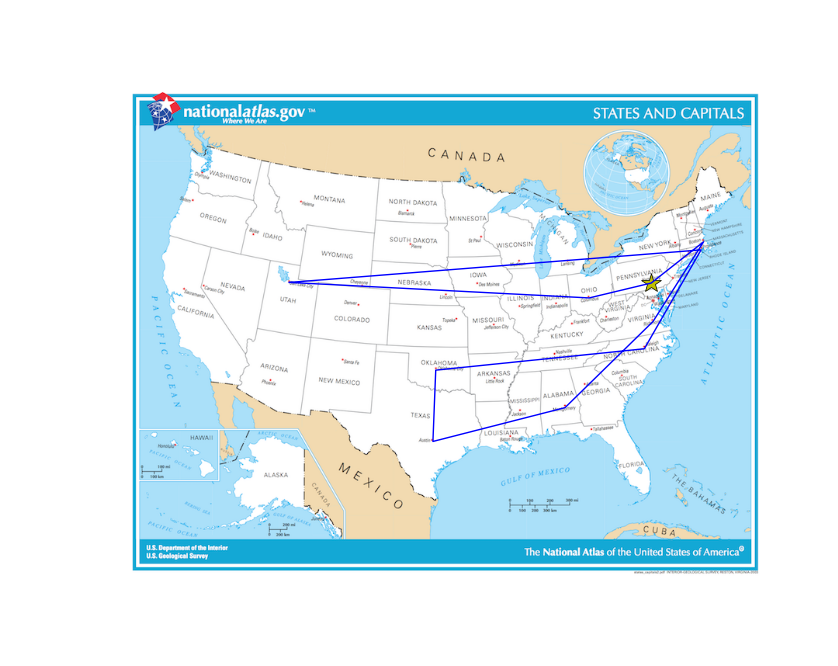

In [20]:
"""Simulation with num_cities = 10 -- with simulated annealing"""
# set the decay rate and initial temperature parameters 
# then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp_10, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

Final path length: 6154.28
[('Harrisburg', [670.8, 244.0]), ('Indianapolis', [548.0, 272.8]), ('Oklahoma City', [392.8, 356.4]), ('Austin', [389.2, 448.4]), ('Raleigh', [662.0, 328.8]), ('Richmond', [673.2, 293.6]), ('Providence', [735.2, 201.2]), ('Boston', [738.4, 190.8]), ('Phoenix', [179.6, 371.2]), ('Montgomery', [559.6, 404.8]), ('Atlanta', [585.6, 376.8]), ('Hartford', [719.6, 205.2]), ('Jackson', [501.6, 409.6]), ('Salt Lake City', [204.0, 243.2]), ('Salem', [80.0, 139.2]), ('Denver', [293.6, 274.0]), ('Des Moines', [447.6, 246.0]), ('Lansing', [563.6, 216.4]), ('Columbia', [632.4, 364.8]), ('Tallahassee', [594.8, 434.8]), ('Little Rock', [469.2, 367.2]), ('Columbus', [590.8, 263.2]), ('Albany', [702.0, 193.6]), ('Saint Paul', [451.6, 186.0]), ('Baton Rouge', [489.6, 442.0]), ('Nashville', [546.4, 336.8]), ('Trenton', [698.8, 239.6]), ('Sacramento', [68.4, 254.0]), ('Boise', [159.6, 182.8]), ('Madison', [500.8, 217.6])]


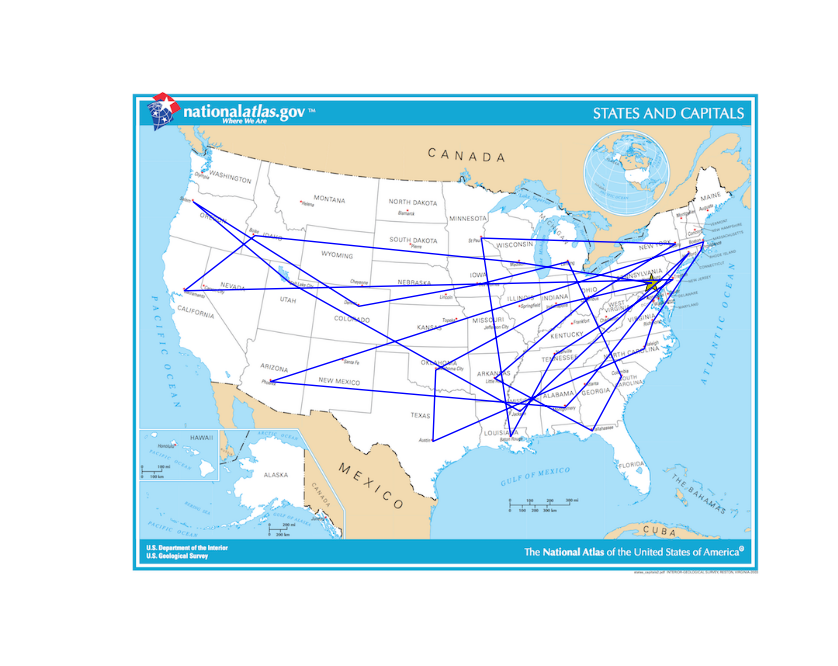

In [21]:
"""Simulation with num_cities = 30 -- with simulated annealing"""
# with num_city = 30
result = simulated_annealing(capitals_tsp_30, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

## VI. Compare Different Schedule Functions 

The exponential schedule is compared with linear, quadratic, and logarithmical schedules defined above in terms of **run time** and **final path_length** for 10-city problem and 30-city problem.

In [42]:
# list of the schedule functions
schedule_list = [('exp', schedule), 
                 ('linear', schedule_linear), 
                 ('quad', schedule_quad), 
                 ('log', schedule_log)]

In [43]:
# compare the schedule functions -- 10-city problem
num_cities = 10
capitals_tsp_10 = TravelingSalesmanProblem(capitals_list[:num_cities])
print("Initial path value: {:.2f}".format(-capitals_tsp_10.get_value()))

temperature=1e6
alpha = 0.95
alpha_log = 2

for name, s in schedule_list:
    start = time()
    result = simulated_annealing(capitals_tsp_10, schedule)
    end = time()
    print("{}: final path length: {:.2f}  time used: {:4f}".format(name, 
                                                                   -result.get_value(), 
                                                                  end-start))

Initial path value: 2656.25
exp: final path length: 1384.20  time used: 0.456871
linear: final path length: 1508.47  time used: 0.460042
quad: final path length: 1958.25  time used: 0.451048
log: final path length: 1441.82  time used: 0.448188


In [44]:
# compare the schedule function -- 30 city problem
num_cities = 30
capitals_tsp_30 = TravelingSalesmanProblem(capitals_list[:num_cities])
print("Initial path value: {:.2f}".format(-capitals_tsp_30.get_value()))

for name, s in schedule_list:
    start = time()
    result = simulated_annealing(capitals_tsp_30, schedule)
    end = time()
    print("{}: final path length: {:.2f}  time used: {:4f}".format(name, 
                                                                   -result.get_value(), 
                                                                  end-start))

Initial path value: 7934.24
exp: final path length: 5874.74  time used: 3.778150
linear: final path length: 6105.53  time used: 3.777111
quad: final path length: 6828.50  time used: 3.785750
log: final path length: 5358.89  time used: 3.804572


Based on the above comparison, all 4 schedule functions achieved smaller final path length than the initial path value (path without optimization by simulated annealing). 

Some findings: 
- The quadratic function seems to be the worst among all 4 functions  
- All 4 functions achieved similar run time (for the specific search space in this problem) 